Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 4.2) 강남역 맛집 리뷰로 알아보는 감성 분류

### 바로가기

- [<Step1. 크롤링> : 네이버 플레이스 리뷰 크롤링](#<Step1.-크롤링>-:-네이버-플레이스-리뷰-크롤링)
    - [네이버 플레이스 API]
    - [맛집 리뷰 정보 크롤링]
- [<Step2. 전처리> : TF-IDF를 이용한 핵심어 추출](#<Step2.-전처리>-:-TF\-IDF를-이용한-핵심어-추출)
    - [형태소 추출하기]
    - [분류 모델의 학습 데이터로 변환하기]
- [<Step3. 분류> : 긍정 부정 리뷰 분류하기](#<Step3.-분류>-:-긍정-부정-리뷰-분류하기)
    - [분류 모델링]
    - [분류 모델 개선]
- [<Step4. 활용> : 중요 키워드 분석](#<Step4.-활용>-:-중요-키워드-분석)
    - [회귀 모델의 피처 영향력 추출]
    - [중요 피처의 형태소]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 네이버 플레이스 리뷰 크롤링

### [네이버 플레이스 API]

![앱 생성 페이지](img/1.png)

-----

In [2]:
import requests
import json

# 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
source_url = "https://store.naver.com/sogum/api/businesses?"

# 검색 규칙 파라미터를 추가합니다.
url_parameter_start = "start=1"
url_parameter_display = "&display="
url_parameter_query = "&query=강남역+고기집"
url_parameter_sorting = "&sortingOrder=precision"
url_concat = source_url + url_parameter_start + \
            url_parameter_display + str(100) + url_parameter_query + url_parameter_sorting

# 반환받은 API 데이터에 json.loads 함수를 사용합니다.
json_data = requests.get(url_concat).text
restaurant_list_data = json.loads(json_data)

# 관련도순 상위 100개의 고기집 리스트 정보를 출력합니다.
print(str(restaurant_list_data)[:100]+"...")

{'query': {'select': '1', 'item': [{'rank': '1', 'region_keyword': '강남역', 'region_type': 'favor', 'r...


In [3]:
restaurant_id_list = []

# 100개씩의 API 호출 결과를 10번 가져옵니다.
for start_idx in [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]:
    
    # 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
    source_url = "https://store.naver.com/sogum/api/businesses?"
    
    # 검색 규칙 파라미터를 추가합니다.
    url_parameter_start = "start=" + str(start_idx)
    url_parameter_display = "&display="
    url_parameter_query = "&query=강남역+고기집"
    url_parameter_sorting = "&sortingOrder=precision"
    url_concat = source_url + url_parameter_start + \
                url_parameter_display + str(start_idx+99) + url_parameter_query + url_parameter_sorting
    print("request_url:", url_concat)
    json_data = requests.get(url_concat).text
    restaurant_list_data = json.loads(json_data)

    # 크롤링에 필요한 각 리뷰 상세 페이지의 id를 추출합니다.
    for restaurant in restaurant_list_data['items']:
        if 'moreBookingReviewsPath' in restaurant:
            restaurant_id_list.append(restaurant['id'])

restaurant_id_list = list(set(restaurant_id_list))

request_url: https://store.naver.com/sogum/api/businesses?start=1&display=100&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=101&display=200&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=201&display=300&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=301&display=400&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=401&display=500&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=501&display=600&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=601&display=700&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=701&display=800&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=80

-----

### [맛집 리뷰 정보 크롤링]

![앱 생성 페이지](img/2.png)

-----

In [4]:
import requests
from bs4 import BeautifulSoup
import re

columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# 리뷰 상세 페이지의 기본 주소입니다.
source_url_head = "https://store.naver.com/restaurants/detail?id="
source_url_tail = "&tab=bookingReview#_tab"

for idx in range(0, len(restaurant_id_list)):
    print("Crawl", str(int(idx/len(restaurant_id_list)*100)), "% complete..")
    
    # 앞서 추출한 리뷰 상세 페이지의 id를 기본 주소의 파라미터로 추가합니다.
    req = requests.get(source_url_head + str(restaurant_id_list[idx]) + source_url_tail)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    review_area = soup.find(name="div", attrs={"class":"review_area"})

    # 리뷰가 없는 페이지는 아무 작업도 수행하지 않습니다.
    if review_area is None:
        continue

    # 개발자 도구로 살펴본 html 구조에서 리뷰의 점수, 텍스트 부분을 추출합니다.
    review_list = review_area.find_all(name="div", attrs={"class":"info_area"})
    for review in review_list:
        score = review.find(name="span", attrs={"class":"score"}).text
        review_txt = review.find(name="div", attrs={"class":"review_txt"}).text

        # 추출한 리뷰의 점수, 리뷰 텍스트를 데이터프레임으로 병합합니다.
        row = [score, review_txt]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Crawl 100 %", "complete")

Crawl 0 % complete..
Crawl 1 % complete..
Crawl 2 % complete..
Crawl 4 % complete..
Crawl 5 % complete..
Crawl 7 % complete..
Crawl 8 % complete..
Crawl 10 % complete..
Crawl 11 % complete..
Crawl 12 % complete..
Crawl 14 % complete..
Crawl 15 % complete..
Crawl 17 % complete..
Crawl 18 % complete..
Crawl 20 % complete..
Crawl 21 % complete..
Crawl 22 % complete..
Crawl 24 % complete..
Crawl 25 % complete..
Crawl 27 % complete..
Crawl 28 % complete..
Crawl 30 % complete..
Crawl 31 % complete..
Crawl 32 % complete..
Crawl 34 % complete..
Crawl 35 % complete..
Crawl 37 % complete..
Crawl 38 % complete..
Crawl 40 % complete..
Crawl 41 % complete..
Crawl 42 % complete..
Crawl 44 % complete..
Crawl 45 % complete..
Crawl 47 % complete..
Crawl 48 % complete..
Crawl 50 % complete..
Crawl 51 % complete..
Crawl 52 % complete..
Crawl 54 % complete..
Crawl 55 % complete..
Crawl 57 % complete..
Crawl 58 % complete..
Crawl 60 % complete..
Crawl 61 % complete..
Crawl 62 % complete..
Crawl 64 % comple

In [5]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if int(x) > 3 else 0)
print(df.shape)
df.head()

(545, 3)


score                      review  y
0     5            친절하시고 깔끔하고 좋았습니다  1
1     5                  조용하고 고기도 굿  1
2     4      갈비탕과 냉면, 육회비빔밥이 맛있습니다.  1
3     4  대체적으로 만족하나\n와인의 구성이 살짝 아쉬움  1
4     5       고기도 맛있고 서비스는 더 최고입니다~  1

In [6]:
df.to_csv("review_data.csv", index=False)
df = pd.read_csv("review_data.csv")

-----

# <Step2. 전처리> : TF-IDF를 이용한 핵심어 추출

### [형태소 추출하기]

##### 한글 텍스트로 전처리

In [7]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [8]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

score  y                   ko_text
0      5  1          친절하시고 깔끔하고 좋았습니다
1      5  1                조용하고 고기도 굿
2      4  1      갈비탕과 냉면 육회비빔밥이 맛있습니다
3      4  1  대체적으로 만족하나와인의 구성이 살짝 아쉬움
4      5  1      고기도 맛있고 서비스는 더 최고입니다

-----

##### 형태소 단위로 추출

In [9]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'][0])
print(result)

['친절하시고/Adjective', '깔끔하고/Adjective', '좋았습니다/Adjective']


-----

### [분류 모델의 학습 데이터로 변환하기]

##### corpus index 생성하기

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [11]:
X.shape

(545, 3030)

In [12]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'친절하시고/Adjective': 2647, '깔끔하고/Adjective': 428, '좋았습니다/Adjective': 2403, '조용하고/Adjective': 2356, '고..


In [13]:
print(df['ko_text'][0])
print(X[0])

친절하시고 깔끔하고 좋았습니다
0
  (0, 2403)	1
  (0, 428)	1
  (0, 2647)	1


-----

##### TF-IDF로 변환

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [15]:
print(X.shape)
print(X[0])

(545, 3030)
  (0, 2647)	0.5548708693511647
  (0, 2403)	0.48955631270748484
  (0, 428)	0.6726462183300624


-----

# <Step3. 분류> : 긍정 부정 리뷰 분류하기

### [분류 모델링]

##### 데이터셋 분리

In [16]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(381, 3030)
(164, 3030)


-----

##### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.90
Precision : 0.896
Recall : 1.000
F1 : 0.945


In [18]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  0  17]
 [  0 147]]


AUC : 0.843


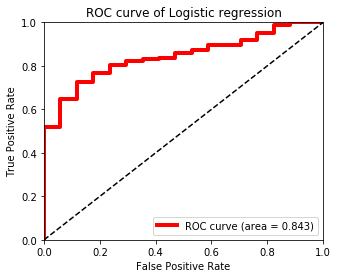

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

------

### [분류 모델 개선]

##### 클래스 불균형 문제 해결하기

In [20]:
# y가 0과 1을 각각 얼마나 가지고 있는지를 출력합니다.
df['y'].value_counts()

1    492
0     53
Name: y, dtype: int64

In [21]:
# 1:1 비율로 랜덤 샘플링을 수행합니다.
positive_random_idx = df[df['y']==1].sample(50, random_state=30).index.tolist()
negative_random_idx = df[df['y']==0].sample(50, random_state=30).index.tolist()

In [22]:
# 랜덤 데이터로 데이터셋을 나눕니다.
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(70, 3030)
(30, 3030)


-----

##### Logistic Regression 다시 학습

In [23]:
# 로지스틱 회귀모델을 다시 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 학습한 모델을 테스트 데이터로 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.73
Precision : 0.833
Recall : 0.625
F1 : 0.714


In [24]:
# Confusion matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[12  2]
 [ 6 10]]


AUC : 0.786


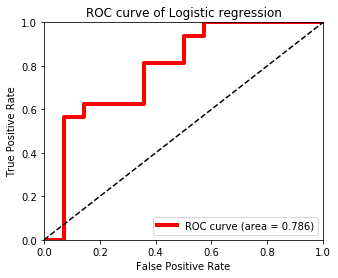

In [25]:
# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

# <Step4. 활용> : 중요 키워드 분석

### [회귀 모델의 피처 영향력 추출]

<BarContainer object of 3030 artists>

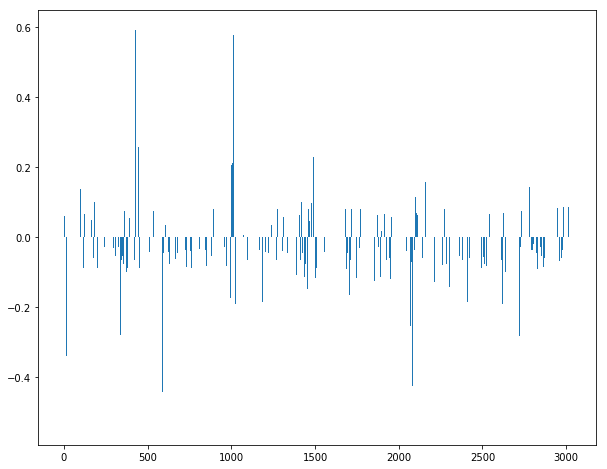

In [26]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [27]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.5927178142528358, 428), (0.5769878803526463, 1013), (0.5235114235362491, 999), (0.40149092170603856, 2247), (0.3985534075477734, 1093)]
[(-0.4066478664910899, 399), (-0.42537727324344454, 2082), (-0.44224690924911886, 589), (-0.5269304382033753, 2069), (-0.5378177643512114, 1309)]


-----

### [중요 피처의 형태소]

In [28]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [29]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')

{2647: '친절하시고/Adjective', 428: '깔끔하고/Adjective', 2403: '좋았습니다/Adjective', 2356: '조용하고/Adjective', 23..


In [30]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

깔끔하고/Adjective 0.5927178142528358
맛있습니다/Adjective 0.5769878803526463
맛있게/Adjective 0.5235114235362491
잘/VerbPrefix 0.40149092170603856
먹었습니다/Verb 0.3985534075477734
생생하니/Adjective 0.3300370018019412
갑니다/Verb 0.306797873445845
강남역/Noun 0.28374742772547235
삼/Modifier 0.2829803592957771
맛있어용/Adjective 0.2796787047543939
갈비살/Noun 0.2796787047543939
친절해요/Adjective 0.26891924743311546
음식/Noun 0.26415722546993586
지인/Noun 0.263876327628184
꼭/Noun 0.25829019511330165
환기/Noun 0.2551627227593666
친절하시고/Adjective 0.25022270914319966
합/Noun 0.23951099136474382
먹음/Noun 0.23138920870364946
비싸다여/Adjective 0.23099662852083655


In [31]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

을/Josa -0.25366015507612083
분/Noun -0.25504571112575497
종업원/Noun -0.26536376012252444
조금/Noun -0.26784253891816473
명/Noun -0.27667512111534265
를/Josa -0.2789661354121658
그/Determiner -0.2813369169062724
테이블/Noun -0.2841799053790502
시끄러워요/Adjective -0.28754346395089153
ㅠㅠㅠㅠ/KoreanParticle -0.28754346395089153
점/Noun -0.31256245576673186
비해/Verb -0.3248478697508706
ㅠㅠ/KoreanParticle -0.34006346144893446
서비스/Noun -0.37997616052065675
주문/Noun -0.3863198639858679
기대이하였음/Verb -0.4066478664910899
이/Josa -0.42537727324344454
는/Josa -0.44224690924911886
은/Josa -0.5269304382033753
별로/Noun -0.5378177643512114


-----

### `[미니 퀴즈 - 4.3]`
- `피처 영향력에 따라 정렬된 형태소에서, 품사별 긍정 형태소 10개와 부정 형태소 10개를 탐색해 보세요.` 
    - “/”로 구분되어있는 정보를 활용하여 품사별 형태소를 추출할 수 있습니다.

In [32]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [33]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('강남역/Noun', 0.28374742772547235),
 ('갈비살/Noun', 0.2796787047543939),
 ('음식/Noun', 0.26415722546993586),
 ('지인/Noun', 0.263876327628184),
 ('꼭/Noun', 0.25829019511330165),
 ('환기/Noun', 0.2551627227593666),
 ('합/Noun', 0.23951099136474382),
 ('먹음/Noun', 0.23138920870364946),
 ('데넘/Noun', 0.23099662852083655),
 ('생/Noun', 0.22772145677353592)]

In [34]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('깔끔하고/Adjective', 0.5927178142528358),
 ('맛있습니다/Adjective', 0.5769878803526463),
 ('맛있게/Adjective', 0.5235114235362491),
 ('생생하니/Adjective', 0.3300370018019412),
 ('맛있어용/Adjective', 0.2796787047543939),
 ('친절해요/Adjective', 0.26891924743311546),
 ('친절하시고/Adjective', 0.25022270914319966),
 ('비싸다여/Adjective', 0.23099662852083655),
 ('입니다/Adjective', 0.228193383774027),
 ('좋아요/Adjective', 0.21850140646010266)]